In [49]:
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import numpy as np

Firstly we need to **check the use of GPU**, since the **speedup** provided by it, is essential for running our complex code.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d61d5a65-5f4a-377e-8dc3-01ab655fcebc)


In the following, we will use **mixed precision training** in order for our **CNN model to run faster and use less memory**. Among NVIDIA GPUs offered by Google Colab, those with **compute capability 7.0 or higher** will see the greatest performance benefit from mixed precision. Therefore, we get sure that we have access to a **TESLA T4**.

In [6]:
# Importing tensorflow datasets(advantage: data is already in tensor format)
import tensorflow_datasets as tfds

In [7]:
# Listing all available datasets and checking for our dataset(Food101)
datasets_list = tfds.list_builders()
print("food101" in datasets_list) 

True


Loading the data from our dataset using the built-in function `tdfs.load()` which also provides the split into **train** and **test** subsets. Below we can see a third variable called `ds_info` which contains a general information for the dataset. 

In [8]:
(train_data, test_data), ds_info = tfds.load(name="food101", # name of the dataset that we will get from TensorFlow dataset
                                             split=["train", "validation"], # 2 categories/groups for splitting our data
                                             shuffle_files=True, # we want our files to shuffle while the dataset is downloading
                                             as_supervised=True, # we want to keep the labels(class names), data get returned in tuple format (sample/image, label)
                                             with_info=True) # we want to include dataset metadata In this case, tfds.load() will return a tuple (train data, test data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteTVVUS3/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteTVVUS3/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


So, we downloaded the dataset as a Google Colab instance anot not in our machine, which is an advantage especially when working on such a large dataset.

In [9]:
# Becoming one with the data, by accessing the above variable ds_info (metadata)
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

We can clearly see above that we are working on images, which have a certain **shape**(width, height, number of color codes/channels). **Image type** is `tf.uint8`, which we need to convert into the preferred type of neural networks. Secondly, we have our **labels**, representing 101 food classes.

In [10]:
# Getting first 5 class names using "names" attribute
class_names = ds_info.features["label"].names
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [12]:
# Taking one sample of the training data using the built-in method, "take()"
train_one_sample = train_data.take(1) 
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
# Looping through our single training sample and getting some info from the image_tensor and label.
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (382, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 52
  Class name (str form): gyoza
        


Above we can see that our **labels** are **not hot-encoded**, because in that case they would be represented by arrays of 0 and 1, instead of an `int` value.

In [14]:
# Printing an image tensor from TFDS's Food101
image

<tf.Tensor: shape=(382, 512, 3), dtype=uint8, numpy=
array([[[207, 220, 237],
        [207, 220, 237],
        [207, 220, 236],
        ...,
        [ 10,  11,  13],
        [ 11,  12,  14],
        [ 12,  13,  15]],

       [[208, 219, 237],
        [207, 220, 236],
        [208, 220, 236],
        ...,
        [  9,  10,  12],
        [ 10,  11,  13],
        [ 11,  12,  14]],

       [[216, 225, 242],
        [213, 225, 239],
        [214, 223, 238],
        ...,
        [ 11,  12,  14],
        [ 12,  13,  15],
        [ 12,  13,  15]],

       ...,

       [[ 33,  10,  16],
        [ 34,  11,  17],
        [ 33,  12,  17],
        ...,
        [ 10,   6,   5],
        [ 13,   7,   7],
        [ 15,   9,   9]],

       [[ 37,  12,  18],
        [ 36,  13,  19],
        [ 35,  15,  17],
        ...,
        [ 14,  10,   9],
        [ 19,  13,  13],
        [ 21,  15,  15]],

       [[ 39,  14,  20],
        [ 37,  14,  20],
        [ 36,  14,  17],
        ...,
        [ 19,  15,  1

Our data is also **not normalized**, so the values of the color channels are not between 0 and 1(how the neural networks prefer images to be input). So, currently, we have values between 0 and 255, just like shown below:

In [17]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

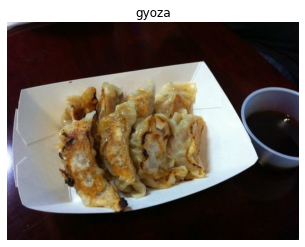

In [20]:
# Plotting the above random image
plt.imshow(image)
plt.title(class_names[label.numpy()]) # adding title to image by indexing the respective element on class_names list
plt.axis(False);

**Preprocessing our data**


---



Neural networks perform best when data is in a certain way(**normalized**, **batched** etc.). So in order to get ready for the neural network, we need a preprocessing function map our data.

Our data is currently:

- In `uint8` data type
- Represented by different size tensors
- Not scaled/normalized (the pixel values are between 0 & 255)

Whereas, models like data to be:

- In `float32` data type
- Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))
- Scaled (values between 0 & 1)

In [21]:
# A function which preprocesses images, to make them ready for the model that we will build
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels], so (224, 224, 3)
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape/resize image
  return tf.cast(image, tf.float32), label # return a tuple containing the image/sample in float32 datatype and the respective label

In [23]:
# Preprocessing a single image and checking the respective output(only the image not the label)
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[207 220 237]
  [207 220 237]
  [207 220 236]
  ...
  [ 10  11  13]
  [ 11  12  14]
  [ 12  13  15]]

 [[208 219 237]
  [207 220 236]
  [208 220 236]
  ...
  [  9  10  12]
  [ 10  11  13]
  [ 11  12  14]]]...,
Shape: (382, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[207.12596  219.87404  236.77328 ]
  [206.75159  219.39891  235.39891 ]
  [206.33514  216.86098  232.36958 ]
  ...
  [ 10.433058  11.433058  13.433058]
  [  9.974804  10.974804  12.974804]
  [ 11.004499  12.004499  14.004499]]

 [[214.51498  225.25287  240.26627 ]
  [214.24043  223.17825  238.07462 ]
  [213.40561  221.28954  234.25638 ]
  ...
  [ 12.571472  13.571472  15.571472]
  [ 11.928558  12.928558  14.928558]
  [ 11.941964  12.941964  14.941964]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


As we can see above, our data is still **not normalized/scaled**. This due to the fact that, we will use a pretrained model called `EfficientNetB0`, which provides a rescaling layer built-in. The reason why we are using this specific model is because it has achieved quite high results in terms of image classification. This way we will also discover the power of **Transfer Learning** in building a deep learning model.

**Batching and preparing our dataset**

Advantages of turning images into batches:
1.   75750 images might not fit into the memory of our processor/GPU, so dealing with the entire dataset at a time could be impossible.
2.   Helps processing data quicklier. 

In [24]:
# Using the built-in map() function to apply the preprocessing function that we built above,
# to all the samples of our training subset.
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# tf.data.AUTOTUNE automatically tunes the number of processors it uses. It suggests to 
# TensorFlow to use all the compute power it finds, since we deal with an extremely 
# large amount of data. 

# Shuffle train_data, turn it into batches and prefetch it (load it faster)
# We also shuffled the data when we downloaded our dataset but just to be safe, we shuffle 
# it again, so that our neural network doesn't learn any order. 
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
# buffer_size indicates the number of samples to get shuffled at the same time. Ideally it should 
# have been equal to the total number of samples that comprise our dataset.
# batch_size has a default value of 32 

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches and prefetch them (no need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [25]:
# Checking the results of the code above
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

**Creating modelling callbacks**

Since we're going train on a very large amount of data, training can take a long time and it's a good idea to set up some modelling callbacks. Thanks to this, our model's training logs are tracked and the model is checkpointed (saved) after various training milestones.

`tf.keras.callbacks.TensorBoard()` - Enables visualizations for TensorBoard, a tool for providing the measurements and visualizations needed during the machine learning workflow.

`tf.keras.callbacks.ModelCheckpoint()` - Saves our model's progress at various intervals so we can load and reuse it later without having to retrain it(**by loading the best weights saved during the first training**). It is also helpful while performing model fine-tuning.

In [38]:
# A function that stores the results generated by tensorboard callback, while fitting the model.
def create_tensorboard_callback(dir_name, exp_name):
  """
  Creates a TensorBoard callback instance to store log files.

  Stores log files with the filepath:
    "dir_name/exp_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files in Google Colab
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + exp_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir # the path of the directory where to save the log files to be parsed by TensorBoard
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [27]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # save only the best weights
                                                      save_weights_only=True, # save only the model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

**Setting up mixed precision training**

In [28]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 
# This tells TensorFlow to use mixed precision training for every part that it can do that.
# This in order to use up to 3x speedup on modern GPUs, thanks to a combination of float32 and float16 data types.

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [29]:
# Checking the global dtype policy (the policy which will be used by layers in our model) 
# using the mixed_precision.global_policy() method.
mixed_precision.global_policy() 

<Policy "mixed_float16">

**Building feature extraction model**

Feature extraction:
*   one of the alternatives of **transfer learning**(because someone can have already built a very good model for image classification)
*   uses a pretrained model, freezing all the layers of it (make them not trainable/tunable) and training only the layers(output layer) that we add to this base model.

So the main idea is to take an existing computer vision architecture that has learned a lot in a similar domain and adapt that to our use case. And this model performs much better than from scratch.

In [30]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Creating base model
input_shape = (224, 224, 3) 
# Using an EfficientNetB0 as the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # since we want to add our own output layer
base_model.trainable = False # freeze base model layers(prelearned patterns) 

# Creating Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False) # set base_model to inference mode only

x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)

x = layers.Dense(len(class_names))(x) # since we want one output neuron per class 
# Creating the output layer with float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

# Generating the model
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [31]:
# Compiling the model
model.compile(loss="sparse_categorical_crossentropy", # requires labels to be non-onehot encoding, and onehot encoding is implemented inside the function.
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [32]:
# Checking out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [33]:
# Checking the attributes of layers in our model
for layer in model.layers:
  print(f"Layer name: {layer.name}, Is trainable: {layer.trainable}, Dtype: {layer.dtype}, Dtype policy: {layer.dtype_policy}") # Check the dtype policy of layers

Layer name: input_layer, Is trainable: True, Dtype: float32, Dtype policy: <Policy "float32">
Layer name: efficientnetb0, Is trainable: False, Dtype: float32, Dtype policy: <Policy "mixed_float16">
Layer name: pooling_layer, Is trainable: True, Dtype: float32, Dtype policy: <Policy "mixed_float16">
Layer name: dense, Is trainable: True, Dtype: float32, Dtype policy: <Policy "mixed_float16">
Layer name: softmax_float32, Is trainable: True, Dtype: float32, Dtype policy: <Policy "float32">


**Fitting the feature extraction model**

In [39]:
history_1 = model.fit(train_data, 
                      epochs=3, 
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)), # to save time per epoch, we'll only validate on 15% of the test data
                      callbacks=[create_tensorboard_callback("training_logs", 
                                                             "exp1"),
                      model_checkpoint])

Saving TensorBoard log files to: training_logs/exp1/20220607-132654
Epoch 1/3
2368/2368 [==============================] - 193s 74ms/step - loss: 1.8156 - accuracy: 0.5576 - val_loss: 1.2357 - val_accuracy: 0.6761
Epoch 2/3
2368/2368 [==============================] - 171s 72ms/step - loss: 1.2917 - accuracy: 0.6662 - val_loss: 1.1351 - val_accuracy: 0.6960
Epoch 3/3
2368/2368 [==============================] - 176s 74ms/step - loss: 1.1430 - accuracy: 0.7019 - val_loss: 1.0809 - val_accuracy: 0.7153


In [40]:
# Evaluating model on whole test dataset
results_1 = model.evaluate(test_data)
results_1

790/790 [==============================] - 53s 67ms/step - loss: 1.0827 - accuracy: 0.7077


[1.0827194452285767, 0.7077227830886841]

Our feature extraction model is performing well. Test accuracy above is higher than training accuracy due to the fact that we used the entire training subset to train our model and only 15% of the testing subset to test that.

In [41]:
# Cloning our model and check its summary
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [45]:
# Loading checkpointed weights(the best ones saved from the model above) into cloned_model
cloned_model.set_weights(model.get_weights())

In [46]:
# Compiling cloned_model (with same parameters as the original model)
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [47]:
# Evalauting cloned model with loaded weights
results_1_cloned_model = cloned_model.evaluate(test_data)

790/790 [==============================] - 50s 61ms/step - loss: 1.0827 - accuracy: 0.7077


Our cloned model with loaded weight's results should be very close to the original model's results. Let's check that:

In [51]:
np.allclose(results_1, results_1_cloned_model)

True

**Preparing our model's layers for fine-tuning**

**Fine tuning** - use the prelearned patterns of the existing pretrained model and "fine-tune" many or all the underlying layers.

We will work mostly on the cloned_model, in order to keep the original one unchanged.

In [52]:
# Checking how many layers has the base model
len(model.layers[1].layers)

237

In [53]:
# Another way to do that
len(base_model.layers)

237

In [55]:
# Converting all layers of the base model inside the cloned_model to trainable
cloned_model.layers[1].trainable = True

# Checking all the layers of the cloned_model after applying the change above
for i, layer in enumerate(cloned_model.layers):
  print(i, layer.name, layer.trainable)

0 input_layer True
1 efficientnetb0 True
2 pooling_layer True
3 dense True
4 softmax_float32 True


As we can see from above, we have unfreezed the pretrained model, `EfficentNetB0`, by setting **all of its layers to trainable/tunable**. 
The evidence for that:


In [59]:
for i, layer in enumerate(cloned_model.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 stem_conv_pad True
4 stem_conv True
5 stem_bn True
6 stem_activation True
7 block1a_dwconv True
8 block1a_bn True
9 block1a_activation True
10 block1a_se_squeeze True
11 block1a_se_reshape True
12 block1a_se_reduce True
13 block1a_se_expand True
14 block1a_se_excite True
15 block1a_project_conv True
16 block1a_project_bn True
17 block2a_expand_conv True
18 block2a_expand_bn True
19 block2a_expand_activation True
20 block2a_dwconv_pad True
21 block2a_dwconv True
22 block2a_bn True
23 block2a_activation True
24 block2a_se_squeeze True
25 block2a_se_reshape True
26 block2a_se_reduce True
27 block2a_se_expand True
28 block2a_se_excite True
29 block2a_project_conv True
30 block2a_project_bn True
31 block2b_expand_conv True
32 block2b_expand_bn True
33 block2b_expand_activation True
34 block2b_dwconv True
35 block2b_bn True
36 block2b_activation True
37 block2b_se_squeeze True
38 block2b_se_reshape True
39 block2b_se_reduce True
40 block

If we worked on a smaller dataset, we could have converted only the last 10 layers of the base model to trainable. But in our case we decided to keep all of them unfrozen. Since we have a large dataset, the risk for overfitting is much smaller.

Now, we will also train for longer(fine-tuning a deep learning model with over 200 layers using over 75000 images). This means that our new model might need a couple of hours to train. In order to avoid this problem, we will stop training when our model stops improving. To achieve this, we will use the `EarlyStopping`callback. It  monitors a specified model performance metric (e.g. `val_loss`) and when it stops improving for a specified number of `epochs`, automatically stops training. Combining it with another `ModelCheckpoint` callback, enables us to use an unlimited number of `epochs` and also to save the best performing model automatically.

In [60]:
# Setting up EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # use the validation loss metric to determine if the model is improving or not
                                                  patience=3) # if validation loss decreases for 3 epochs in a row, stop training automatically

# Setting up the ModelCheckpoint callback
checkpoint_path = "fine_tuning_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

We also need to take care of another essential hyperparameter, `learning_rate`. We need to significantly reduce it while fitting the model, if the latter stops improving. So as training goes on and our model gets closer and closer to it's ideal performance (also called convergence), we want the amount it learns to be less and less. For this we can use `ReduceLROnPlateau` callback, another very important feature provided by tensorflow. 

In [61]:
# Setting up the learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  # use the same metric as in case of EarlyStopping callback
                                                 factor=0.2, # reduce 5 times the learning rate
                                                 patience=2, 
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [62]:
# Compiling the cloned_model, whose layers are all trainable
cloned_model.compile(loss="sparse_categorical_crossentropy", 
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default one used by Adam optimizer
                        metrics=["accuracy"])

In [63]:
# Fine-tunning our cloned_model(fitting the model)
history_2 = cloned_model.fit(train_data,
                             epochs=100, # maximum number of epochs 
                             steps_per_epoch=len(train_data),
                             validation_data=test_data,
                             validation_steps=int(0.15 * len(test_data)), # training again using only 15% of test dataset
                             callbacks=[create_tensorboard_callback("training_logs", "exp2"), # save the model performance
                                        model_checkpoint, # save only the best model during training
                                        early_stopping, # stop model after 3 epochs of no improvements
                             reduce_lr]) # reduce the learning rate after 2 epochs of no improvements

Saving TensorBoard log files to: training_logs/exp2/20220607-143204
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9205 - accuracy: 0.7530INFO:tensorflow:Assets written to: fine_tuning_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tuning_checkpoints/assets


2368/2368 [==============================] - 384s 155ms/step - loss: 0.9205 - accuracy: 0.7530 - val_loss: 0.8136 - val_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 2/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.5787 - accuracy: 0.8401INFO:tensorflow:Assets written to: fine_tuning_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tuning_checkpoints/assets


2368/2368 [==============================] - 373s 157ms/step - loss: 0.5788 - accuracy: 0.8401 - val_loss: 0.7765 - val_accuracy: 0.7847 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 334s 140ms/step - loss: 0.3272 - accuracy: 0.9075 - val_loss: 0.8764 - val_accuracy: 0.7765 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1751 - accuracy: 0.9488
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 336s 141ms/step - loss: 0.1751 - accuracy: 0.9488 - val_loss: 0.9476 - val_accuracy: 0.7850 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 332s 140ms/step - loss: 0.0366 - accuracy: 0.9915 - val_loss: 1.0517 - val_accuracy: 0.8014 - lr: 2.0000e-05


In [64]:
# Evaluate the fine_tuned cloned_model on the entire test dataset
results_cloned_model_fine_tuned = cloned_model.evaluate(test_data) 

790/790 [==============================] - 50s 63ms/step - loss: 1.0420 - accuracy: 0.7950


We can see **a considerable improvement of 9%** in terms of our model accuracy on the test subset. And this thanks to fine-tuning our model.
Moreover, we managed to beat the results mentioned in the `DeepFood` paper for Food101(**77.4% top-1 accuracy**) : https://arxiv.org/ftp/arxiv/papers/1606/1606.05675.pdf

In [65]:
# Save model to Google Drive
cloned_model.save("/content/drive/MyDrive/data_mining_project/fine_tuned_model/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_mining_project/fine_tuned_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_mining_project/fine_tuned_model/assets


**Link of the CNN model that we built:** https://drive.google.com/drive/folders/1CCFU7KG7_iZA51Tjk0emMboxDrv1uFj-?usp=sharing

**Visualizing our original model performance:**

In [66]:
# A function that will plot 4 different loss curves representing our CNN model
def plot_model_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object, which contains all the events recorded while fitting the model
  """ 
  loss = history.history['loss'] # training loss
  val_loss = history.history['val_loss'] # validation/test loss

  accuracy = history.history['accuracy'] # training accuracy
  val_accuracy = history.history['val_accuracy'] # validation/test accuracy

  epochs = range(len(history.history['loss'])) # number of training/testing iterations

  # Plot loss(training vs validation)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy(training vs validation)
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

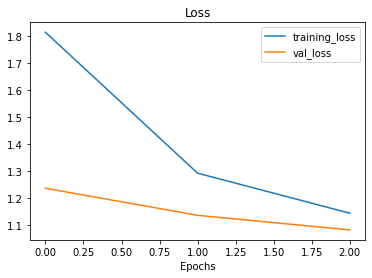

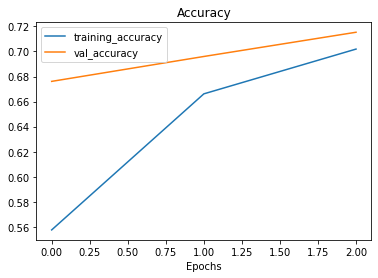

In [67]:
plot_model_loss_curves(history_1)

**Conclusion:** Both loss and accuracy plots look great in the feature extracted model(first one that we built). 

**Visualizing our fine_tuned model performance:**

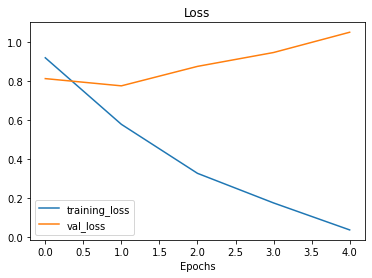

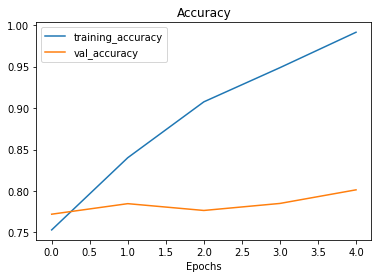

In [68]:
plot_model_loss_curves(history_2)

**Conclusion:** In this case despite the higher value of the test/validation accuracy that we reached, we can see that our model suffers from overfitting. So learning the training dataset too well and not being able to generalize to unseen data. This is probably caused by the great number of layers that we unfreezed in the base model, to prepare that for fine-tuning. Maybe a small number of trainable/tunable layers in the pretrained model could reduce overfitting. Ideally loss/accuracy curves for training and validation should be very similar to each other.